<h1>Assignment 4: Fairness with IBM AIF360</h1>

In [1]:
pip install aif360[all]

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install aif360[LawSchoolGPA]

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install aif360[AdversarialDebiasing]

Note: you may need to restart the kernel to use updated packages.


<h2>Exercise 1</h2>

In [4]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

<h3>Part 1: When Race is the Protected Attribute and then we test with Sex as the Protected Attribute</h3>

In [8]:
from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

# Load and preprocess the COMPAS dataset
dataset = load_preproc_data_compas(['race'])

In [9]:
print(dataset)

               instance weights features                                       \
                                         protected attribute                    
                                     sex                race age_cat=25 to 45   
instance names                                                                  
3                           1.0      0.0                 0.0              1.0   
4                           1.0      0.0                 0.0              0.0   
8                           1.0      0.0                 1.0              1.0   
10                          1.0      1.0                 1.0              1.0   
14                          1.0      0.0                 1.0              1.0   
15                          1.0      0.0                 0.0              0.0   
16                          1.0      1.0                 1.0              1.0   
18                          1.0      0.0                 0.0              1.0   
19                          

[5278 rows x 12 columns]


In [10]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

In [11]:
from IPython.display import Markdown, display
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset.favorable_label, dataset.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset.privileged_protected_attributes, 
      dataset.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset.feature_names)

#### Training Dataset shape

(5278, 10)


#### Favorable and unfavorable labels

0.0 1.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['sex', 'race', 'age_cat=25 to 45', 'age_cat=Greater than 45', 'age_cat=Less than 25', 'priors_count=0', 'priors_count=1 to 3', 'priors_count=More than 3', 'c_charge_degree=F', 'c_charge_degree=M']


## Training/Test data

In [12]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Metric for original training data

In [13]:
from aif360.metrics import BinaryLabelDatasetMetric
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.120253


#### Train with and transform the original training data

In [14]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [15]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [16]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


### Change sex to be the protected attribute

In [17]:
dataset_orig_train.protected_attribute_names=(['sex'])
dataset_orig_valid.protected_attribute_names=(['sex'])
dataset_orig_test.protected_attribute_names=(['sex'])

In [18]:
print(dataset_orig_train.protected_attribute_names)

['sex']


In [19]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

<h3>Train Logistic Regression Model</h3>

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [21]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [22]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.1632166 ]
 [0.64301032]
 [0.33215512]
 [0.45062348]
 [0.50629533]
 [0.37148936]
 [0.78786274]
 [0.51228645]
 [0.33215512]
 [0.84689611]]


### Find the optimal classification threshold from the validation set

In [23]:
from aif360.metrics import ClassificationMetric

In [24]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6815
Optimal classification threshold (no reweighing) = 0.4852


### Predictions from the original test set at the optimal classification threshold

In [25]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [26]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4852


 47%|█████████████████████████████████████▌                                          | 47/100 [00:00<00:00, 431.05it/s]

Balanced accuracy = 0.6660
Statistical parity difference = -0.2619
Disparate impact = 0.6543
Average odds difference = -0.2204
Equal opportunity difference = -0.1893
Theil index = 0.1848


 76%|████████████████████████████████████████████████████████████▊                   | 76/100 [00:00<00:00, 373.31it/s]C:\Users\bengo\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 357.14it/s]


<h4>Disparate Impact (DI)</h4> This metric is a ratio of the rate of favorable outcomes for the unprivileged group to the rate of favorable outcomes for the privileged group. A value of 1 indicates perfect fairness. Values less than 1 indicate less favorable outcomes for the unprivileged group, and values greater than 1 indicate less favorable outcomes for the privileged group.
<h4>Statistical Parity Difference (SPD)</h4> This is the difference in the rate of favorable outcomes received by the unprivileged group to the privileged group. A value of 0 indicates perfect fairness. Negative values indicate bias against the unprivileged group, and positive values indicate bias in favor of the unprivileged group.

As such, we can see that the DI is less than 1, indicating less favorable outcomes for the unprivileged group. In this case, that means less favorable outcomes for males, when we run the model based on race beforehand.

We can also look at the SPD. It is negative, which indicates bias against the unprivileged group. This means that the male population is experiencing bias when we run the model based on race beforehand.

## Imagery of the model and data (optional) [only done for the first one]

In [28]:
import matplotlib.pyplot as plt

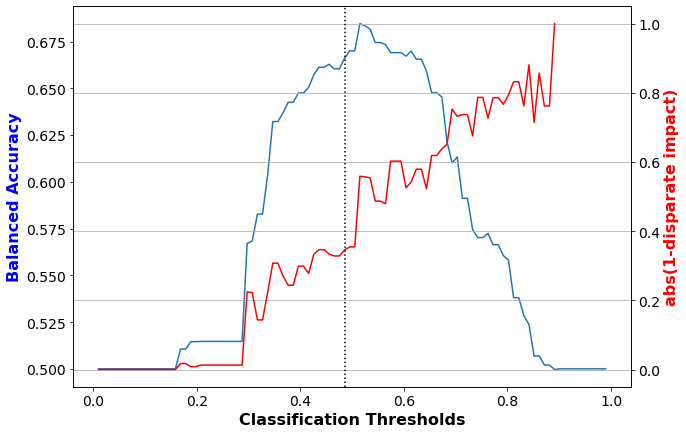

In [29]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

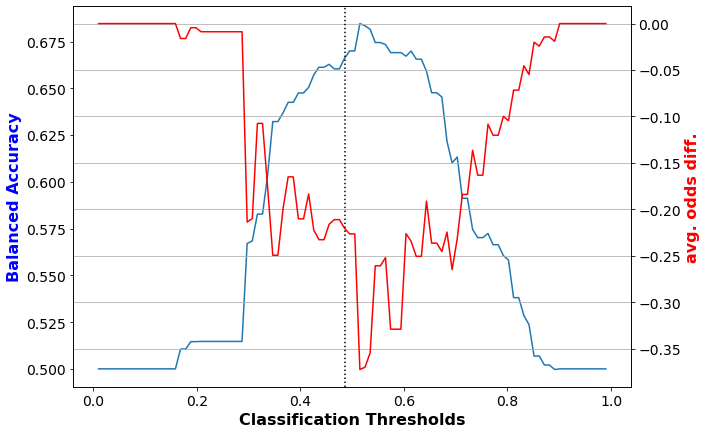

In [30]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [31]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

#### Obtain scores for transformed test set

In [32]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [33]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.4852


 26%|████████████████████▊                                                           | 26/100 [00:00<00:00, 245.28it/s]

Balanced accuracy = 0.6544
Statistical parity difference = -0.1022
Disparate impact = 0.8339
Average odds difference = -0.0600
Equal opportunity difference = -0.0359
Theil index = 0.2202


 78%|██████████████████████████████████████████████████████████████▍                 | 78/100 [00:00<00:00, 244.89it/s]C:\Users\bengo\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\bengo\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 259.07it/s]


The DI is closer to 1 now, which implies more fairness, but there is still some unfairness for the unprivileged group. The SPD is closer to 0, which implies less bias, but there is still some bias against the unprivileged group.

#### Display results for all thresholds

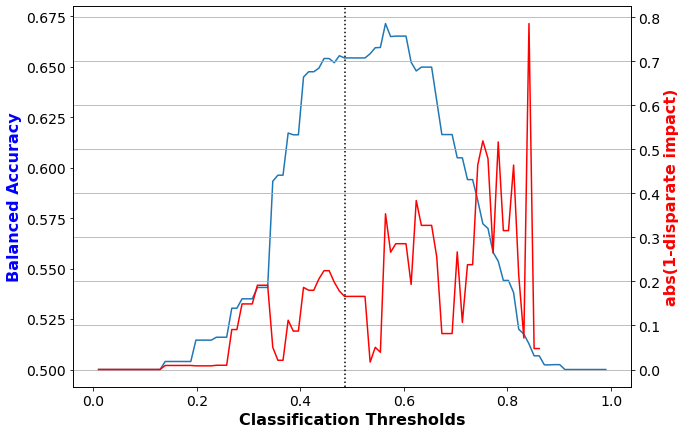

In [34]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is closer to the case.
This implies more fairness than previously.

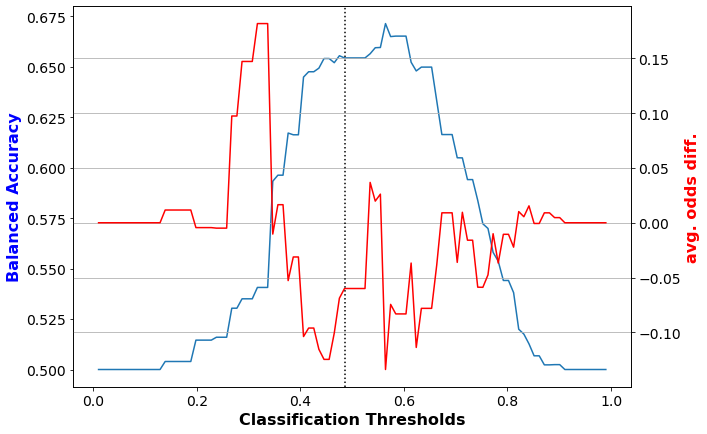

In [35]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is closer to the case.
This implies more fairness than previously seen.

<h3>Part 2: When Sex is the Protected Attribute and then we test with Race as the Protected Attribute</h3>

In [36]:
# Load and preprocess the COMPAS dataset
dataset = load_preproc_data_compas(['sex'])

In [37]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

## Training/Test data

In [38]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Metric for original training data

In [39]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.143121


#### Train with and transform the original training data

In [40]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [41]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [42]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


### Change race to be the protected attribute

In [43]:
dataset_orig_train.protected_attribute_names=(['race'])
dataset_orig_valid.protected_attribute_names=(['race'])
dataset_orig_test.protected_attribute_names=(['race'])

In [44]:
print(dataset_orig_train.protected_attribute_names)

['race']


In [45]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

<h3>Train Logistic Regression Model</h3>

In [46]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [47]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.40978573]
 [0.15317496]
 [0.70083489]
 [0.73924136]
 [0.53193139]
 [0.37813881]
 [0.53193139]
 [0.88694563]
 [0.33703946]
 [0.32678371]]


### Find the optimal classification threshold from the validation set

In [48]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6518
Optimal classification threshold (no reweighing) = 0.4555


### Predictions from the original test set at the optimal classification threshold

In [49]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4555


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Balanced accuracy = 0.6599
Statistical parity difference = -0.1907
Disparate impact = 0.7647
Average odds difference = -0.1643
Equal opportunity difference = -0.0993
Theil index = 0.1600


 46%|████████████████████████████████████▊                                           | 46/100 [00:00<00:00, 386.53it/s]C:\Users\bengo\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 404.86it/s]


<h4>Disparate Impact (DI)</h4> This metric is a ratio of the rate of favorable outcomes for the unprivileged group to the rate of favorable outcomes for the privileged group. A value of 1 indicates perfect fairness. Values less than 1 indicate less favorable outcomes for the unprivileged group, and values greater than 1 indicate less favorable outcomes for the privileged group.
<h4>Statistical Parity Difference (SPD)</h4> This is the difference in the rate of favorable outcomes received by the unprivileged group to the privileged group. A value of 0 indicates perfect fairness. Negative values indicate bias against the unprivileged group, and positive values indicate bias in favor of the unprivileged group.

As such, we can see that the DI is less than 1, indicating less favorable outcomes for the unprivileged group. In this case, that means less favorable outcomes for non-caucasians, when we run the model on sex beforehand.

We can also look at the SPD. It is negative, which indicates bias against the unprivileged group. This means that the non-caucasian population is experiencing bias when we run the model based on sex beforehand.

<h3>Part 3: Repeat Measurements Considering Age Groups</h3>

<h3>Part 3.1: When Race is the Protected Attribute and then we test with Sex as the Protected Attribute. Additionally, the age is set as less than 25</h3>

In [69]:
# Load and preprocess the COMPAS dataset
dataset = load_preproc_data_compas(['race'])

In [70]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

In [71]:
import pandas as pd

dataset_df = pd.DataFrame(dataset.features, columns=dataset.feature_names)

#age is less than 25 specifically
age_cat = np.argmax(dataset_df[['age_cat=Less than 25']].values, axis=1).reshape(-1, 1)
priors_count = np.argmax(dataset_df[['priors_count=0', 'priors_count=1 to 3',
                                          'priors_count=More than 3']].values, axis=1).reshape(-1, 1)
c_charge_degree = np.argmax(dataset_df[['c_charge_degree=M', 'c_charge_degree=F']].values, axis=1).reshape(-1, 1)

features = np.concatenate((dataset_df[['sex', 'race']].values, age_cat, priors_count,
                           c_charge_degree, dataset.labels), axis=1)
feature_names = ['sex', 'race', 'age_cat', 'priors_count', 'c_charge_degree']

In [72]:
df = pd.DataFrame(features, columns=feature_names + ['two_year_recid'])
df.head()

,sex,race,age_cat,priors_count,c_charge_degree,two_year_recid
0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,2.0,1.0,1.0
2,0.0,1.0,0.0,2.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0


In [74]:
from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['race'],
                 privileged_classes=[[1]],
                 instance_weights_name=None)

In [75]:
print(dataset.protected_attribute_names)

['race']


## Training/Test data

In [76]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Metric for original training data

In [77]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.125412


#### Train with and transform the original training data

In [78]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [79]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [80]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


### Change race to be the protected attribute

In [81]:
dataset_orig_train.protected_attribute_names=(['sex'])
dataset_orig_valid.protected_attribute_names=(['sex'])
dataset_orig_test.protected_attribute_names=(['sex'])

In [82]:
print(dataset_orig_train.protected_attribute_names)

['sex']


In [83]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

<h3>Train Logistic Regression Model</h3>

In [84]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [85]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.56255249]
 [0.63191948]
 [0.69141064]
 [0.30082376]
 [0.42550598]
 [0.46220747]
 [0.53132053]
 [0.39164768]
 [0.63191948]
 [0.30082376]]


### Find the optimal classification threshold from the validation set

In [86]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6544
Optimal classification threshold (no reweighing) = 0.4654


### Predictions from the original test set at the optimal classification threshold

In [87]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4654


 32%|█████████████████████████▌                                                      | 32/100 [00:00<00:00, 312.01it/s]

Balanced accuracy = 0.6410
Statistical parity difference = -0.3653
Disparate impact = 0.5419
Average odds difference = -0.3338
Equal opportunity difference = -0.3175
Theil index = 0.2298


 59%|███████████████████████████████████████████████▏                                | 59/100 [00:00<00:00, 297.58it/s]C:\Users\bengo\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 320.16it/s]


<h4>Disparate Impact (DI)</h4> This metric is a ratio of the rate of favorable outcomes for the unprivileged group to the rate of favorable outcomes for the privileged group. A value of 1 indicates perfect fairness. Values less than 1 indicate less favorable outcomes for the unprivileged group, and values greater than 1 indicate less favorable outcomes for the privileged group.
<h4>Statistical Parity Difference (SPD)</h4> This is the difference in the rate of favorable outcomes received by the unprivileged group to the privileged group. A value of 0 indicates perfect fairness. Negative values indicate bias against the unprivileged group, and positive values indicate bias in favor of the unprivileged group.

As such, we can see that the DI is less than 1, indicating less favorable outcomes for the unprivileged group. In this case, that means less favorable outcomes for males, when we run the model based on race beforehand and based on the age category as less than 25.

We can also look at the SPD. It is negative, which indicates bias against the unprivileged group. This means that the male population is experiencing bias when we run the model based on race beforehand and based on the age category as less than 25.

<h3>Part 3.2: When Sex is the Protected Attribute and then we test with Race as the Protected Attribute. Additionally, the age is set as less than 25</h3>

In [50]:
# Load and preprocess the COMPAS dataset
dataset = load_preproc_data_compas(['sex'])

In [51]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [53]:
import pandas as pd

dataset_df = pd.DataFrame(dataset.features, columns=dataset.feature_names)

#age is less than 25 specifically
age_cat = np.argmax(dataset_df[['age_cat=Less than 25']].values, axis=1).reshape(-1, 1)
priors_count = np.argmax(dataset_df[['priors_count=0', 'priors_count=1 to 3',
                                          'priors_count=More than 3']].values, axis=1).reshape(-1, 1)
c_charge_degree = np.argmax(dataset_df[['c_charge_degree=M', 'c_charge_degree=F']].values, axis=1).reshape(-1, 1)

features = np.concatenate((dataset_df[['sex', 'race']].values, age_cat, priors_count,
                           c_charge_degree, dataset.labels), axis=1)
feature_names = ['sex', 'race', 'age_cat', 'priors_count', 'c_charge_degree']

In [54]:
df = pd.DataFrame(features, columns=feature_names + ['two_year_recid'])
df.head()

,sex,race,age_cat,priors_count,c_charge_degree,two_year_recid
0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,2.0,1.0,1.0
2,0.0,1.0,0.0,2.0,1.0,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0


In [55]:
from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['sex'],
                 privileged_classes=[[1]],
                 instance_weights_name=None)

In [56]:
print(dataset.protected_attribute_names)

['sex']


## Training/Test data

In [57]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Metric for original training data

In [58]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.139823


#### Train with and transform the original training data

In [59]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [60]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [61]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


### Change race to be the protected attribute

In [62]:
dataset_orig_train.protected_attribute_names=(['race'])
dataset_orig_valid.protected_attribute_names=(['race'])
dataset_orig_test.protected_attribute_names=(['race'])

In [63]:
print(dataset_orig_train.protected_attribute_names)

['race']


In [64]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

<h3>Train Logistic Regression Model</h3>

In [65]:
# Logistic regression classifier and predictions
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

#### Obtain scores for original validation and test sets

In [66]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
print(dataset_orig_valid_pred.scores[:10])

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

[[0.46280223]
 [0.81342823]
 [0.53349143]
 [0.46208394]
 [0.53349143]
 [0.7690763 ]
 [0.62811269]
 [0.46208394]
 [0.68919468]
 [0.39288792]]


### Find the optimal classification threshold from the validation set

In [67]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6460
Optimal classification threshold (no reweighing) = 0.4654


### Predictions from the original test set at the optimal classification threshold

In [68]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.4654


 27%|█████████████████████▌                                                          | 27/100 [00:00<00:00, 250.21it/s]

Balanced accuracy = 0.6417
Statistical parity difference = -0.3123
Disparate impact = 0.6219
Average odds difference = -0.2809
Equal opportunity difference = -0.2705
Theil index = 0.2190


 57%|█████████████████████████████████████████████▌                                  | 57/100 [00:00<00:00, 261.42it/s]C:\Users\bengo\Anaconda3\lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 325.26it/s]


<h4>Disparate Impact (DI)</h4> This metric is a ratio of the rate of favorable outcomes for the unprivileged group to the rate of favorable outcomes for the privileged group. A value of 1 indicates perfect fairness. Values less than 1 indicate less favorable outcomes for the unprivileged group, and values greater than 1 indicate less favorable outcomes for the privileged group.
<h4>Statistical Parity Difference (SPD)</h4> This is the difference in the rate of favorable outcomes received by the unprivileged group to the privileged group. A value of 0 indicates perfect fairness. Negative values indicate bias against the unprivileged group, and positive values indicate bias in favor of the unprivileged group.

As such, we can see that the DI is less than 1, indicating less favorable outcomes for the unprivileged group. In this case, that means less favorable outcomes for non-caucasians, when we run the model based on sex beforehand and based on the age category as less than 25.

We can also look at the SPD. It is negative, which indicates bias against the unprivileged group. This means that the non-caucasian population is experiencing bias when we run the model based on sex beforehand and based on the age category as less than 25.